# Milestone 2 Phase 2

The milestones were created to evaluate learning in the Hacktiv8 Data Science Full Time Program Phase 2, especially on Deep Learning.

The milestone written by Risqi Rahmatullah, Batch 007.

## Description

The dataset is the data used in this Ahmed H, Traore I, Saad S's research. The dataset was entirely collected from real-world sources. They collected news articles from Reuters.com (news website) for truthful opinions. As for the fake news, they were collected from a fake news dataset on kaggle.com. The dataset consisted of fake news from unreliable websites that Politifact (a fact-checking organization in the USA) has been working with Facebook to stamp out.

For every review, the following information is available:
- Article text
- Article type
- Article label (fake or truthful)
- Article title
- Article dates 

**Acknowledgements**

- Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
- Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

**Source**: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

## Assignment Objectives

*Milestones 2* ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep Computer Vision/NLP.
- Mampu mempersiapkan data untuk digunakan dalam model Computer Vision/NLP.
- Mampu mengimplementasikan Artificial Neural Network dengan data yang ada.
- Mampu menganalisis dan menjelaskan layer yang dibuat.

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


## Libraries

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import tensorflow as tf
import string
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D, LSTM, GRU
from tensorflow.keras.optimizers import Adam

## Data Loading

In [3]:
true_news = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake_news = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
display(true_news.head(), true_news.shape, fake_news.head(), fake_news.shape)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


(21417, 4)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


(23481, 4)

In [4]:
# target labeling and data merging
true_news['label'] = 'true news'
fake_news['label'] = 'fake news'
news = pd.concat([true_news, fake_news], axis=0, ignore_index=True)
display(news.head(), news.shape)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",true news
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",true news
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",true news
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",true news
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",true news


(44898, 5)

## Data Cleaning

### Remove duplicate data

In [5]:
# check duplicate data
news.duplicated().sum()

209

In [6]:
# remove duplicate data
news.drop_duplicates(inplace=True)

### Delete unnecessary columns

In [7]:
news.subject.value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Ada kategori yang sama tetapi penulisannya berbeda. Coba kita periksa kolom 'subject' berdasarkan label.

In [8]:
news.groupby(['label', 'subject']).count()

title   text   date
label     subject                             
fake news Government News   1570   1570   1570
          Middle-east        778    778    778
          News              9050   9050   9050
          US_News            783    783    783
          left-news         4459   4459   4459
          politics          6838   6838   6838
true news politicsNews     11220  11220  11220
          worldnews         9991   9991   9991

Ternyata masing-masing data berita asli dan palsu memiliki kategori berita yang berbeda. Hal ini wajar karena masing-masing data diambil dari sumber yang berbeda. Oleh karena itu, saya tidak menggunakan kolom 'subject'.

Saya juga tidak membutuhkan kolom 'date', sehingga saya memutuskan untuk menghapus kedua kolom tersebut.

In [9]:
del news['subject']
# kolom tanggal juga tidak diperlukan
del news['date']

### Remove missing values

In [10]:
# check whitespace.
news[news.text.str.isspace()]

,title,text,label
8970,Graphic: Supreme Court roundup,,true news
32340,TAKE OUR POLL: Who Do You Think President Trum...,,fake news
32458,Joe Scarborough BERATES Mika Brzezinski Over “...,,fake news
32607,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,fake news
32642,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,fake news
...,...,...,...
43233,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,fake news
43243,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,fake news
43244,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,fake news
43274,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,fake news


Ternyata ada nilai yang hilang pada kolom 'text', sehingga saya memutuskan untuk membuang data yang mengandung nilai yang hilang

In [11]:
news = news[~news.text.str.isspace()]

### Combining column values
Pada akhirnya, semua kolom teks akan dijadikan vektor, jadi saya memutuskan untuk menggabungkan kolom "title" dan "text".
<details>
<summary>translations</summary>
In the end, the all text column will be vectorized, so I decided to combine the "title" and "text" columns
</details>

In [12]:
news['content'] = news['title'] + " " + news['text']

## Exploratory Data Analysis (EDA)

In [13]:
# Uppercase
news['upper'] = news['content'].apply(lambda x: len([x for x in x.split() if x.isupper() and (len(x) > 1)]))
news[['content','upper']].head()

,content,upper
0,"As U.S. budget fight looms, Republicans flip t...",11
1,U.S. military to accept transgender recruits o...,7
2,Senior U.S. Republican senator: 'Let Mr. Muell...,6
3,FBI Russia probe helped by Australian diplomat...,6
4,Trump wants Postal Service to charge 'much mor...,15


In [14]:
# Lowercase
news['lower'] = news['content'].apply(lambda x: len([x for x in x.split() if x.islower()]))
news[['content','lower']].head()

,content,lower
0,"As U.S. budget fight looms, Republicans flip t...",607
1,U.S. military to accept transgender recruits o...,519
2,Senior U.S. Republican senator: 'Let Mr. Muell...,359
3,FBI Russia probe helped by Australian diplomat...,282
4,Trump wants Postal Service to charge 'much mor...,685


In [15]:
# Punctuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

news['punctuation'] = news['content'].apply(lambda x: count_punct(x))
news[['content','punctuation']].head()

,content,punctuation
0,"As U.S. budget fight looms, Republicans flip t...",121
1,U.S. military to accept transgender recruits o...,80
2,Senior U.S. Republican senator: 'Let Mr. Muell...,53
3,FBI Russia probe helped by Australian diplomat...,53
4,Trump wants Postal Service to charge 'much mor...,138


In [16]:
# Hastag
news['hastags'] = news['content'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
news[['content','hastags']].head()

,content,hastags
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


In [17]:
# Numbers / Digits
news['numerics'] = news['content'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
news[['content','numerics']].head()

,content,numerics
0,"As U.S. budget fight looms, Republicans flip t...",7
1,U.S. military to accept transgender recruits o...,2
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,2
4,Trump wants Postal Service to charge 'much mor...,10


### Create text cleaning function

In [18]:
# stopwords
try:
  stop_words = set(stopwords.words("english"))
except:
  nltk.download('stopwords')
  stop_words = set(stopwords.words("english"))

# remove the stopwords and single-character words
def remove_sw_and_sc(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words and len(i) > 1:
            final_text.append(i.strip())
    return " ".join(final_text)

# combine all functions above
def clean_text(text):
    text = text.lower() # convert to lowercase
    text = re.sub('\[.*?\]', '', text) # remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('http\S+|\S+\.com\S+|bit.ly\S+', '', text) # remove url
    text = re.sub(r'\@\S+', '', text) # remove mention
    text = re.sub('[‘’“”…]', '', text) # remove other punctuation
    text = remove_sw_and_sc(text)
    return text

# apply function on review column
news['content'] = news['content'].apply(clean_text)

In [19]:
# Number of Words
news['word_count'] = news['content'].apply(lambda x: len(str(x).split(" ")))
news[['content','word_count']].head()

,content,word_count
0,us budget fight looms republicans flip fiscal ...,447
1,us military accept transgender recruits monday...,381
2,senior us republican senator let mr mueller jo...,270
3,fbi russia probe helped australian diplomat ti...,235
4,trump wants postal service charge much amazon ...,494


In [20]:
# Number of Character
news['char_count'] = news['content'].str.len()
news[['content','char_count']].head()

,content,char_count
0,us budget fight looms republicans flip fiscal ...,3393
1,us military accept transgender recruits monday...,3089
2,senior us republican senator let mr mueller jo...,2026
3,fbi russia probe helped australian diplomat ti...,1855
4,trump wants postal service charge much amazon ...,3700


In [21]:
# Average Words
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/(len(words)+0.000001))

news['avg_word'] = news['content'].apply(lambda x: avg_word(x)).round(1)
news[['content','avg_word']].head()

,content,avg_word
0,us budget fight looms republicans flip fiscal ...,6.6
1,us military accept transgender recruits monday...,7.1
2,senior us republican senator let mr mueller jo...,6.5
3,fbi russia probe helped australian diplomat ti...,6.9
4,trump wants postal service charge much amazon ...,6.5


In [22]:
# informasi angka yang diekstrak dari teks berita
news.head()

,title,text,label,content,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,true news,us budget fight looms republicans flip fiscal ...,11,607,121,0,7,447,3393,6.6
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,true news,us military accept transgender recruits monday...,7,519,80,0,2,381,3089,7.1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,true news,senior us republican senator let mr mueller jo...,6,359,53,0,1,270,2026,6.5
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,true news,fbi russia probe helped australian diplomat ti...,6,282,53,0,2,235,1855,6.9
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,true news,trump wants postal service charge much amazon ...,15,685,138,0,10,494,3700,6.5


In [23]:
# ringkasan statistik dari teks berita palsu
news[news.label == 'fake news'].describe()

,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
count,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000,22848.000000
mean,9.875306,350.037640,62.652661,0.338454,1.807948,245.019214,1839.407957,6.442166
std,11.834064,332.913916,82.304659,1.338197,3.339563,228.004754,1776.135850,0.412083
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4.000000,199.000000,34.000000,0.000000,0.000000,148.000000,1092.750000,6.200000
50%,7.000000,298.000000,50.000000,0.000000,1.000000,207.000000,1544.000000,6.400000
75%,12.000000,415.000000,73.000000,0.000000,2.000000,284.000000,2130.250000,6.700000
max,307.000000,6603.000000,7295.000000,43.000000,118.000000,4827.000000,38676.000000,19.600000


In [24]:
# ringkasan statistik dari teks berita asli
news[news.label == 'true news'].describe()

,upper,lower,punctuation,hastags,numerics,word_count,char_count,avg_word
count,21210.000000,21210.000000,21210.000000,21210.000000,21210.000000,21210.000000,21210.000000,21210.000000
mean,6.128996,313.805139,52.118576,0.018859,2.392221,233.553890,1769.012777,6.572489
std,6.231227,224.015800,36.846934,0.254569,3.011444,158.546112,1200.973207,0.320075
min,0.000000,13.000000,4.000000,0.000000,0.000000,21.000000,143.000000,5.000000
25%,2.000000,119.000000,22.000000,0.000000,0.000000,94.000000,709.000000,6.400000
50%,4.000000,292.000000,46.000000,0.000000,1.000000,217.000000,1648.000000,6.600000
75%,8.000000,429.000000,70.000000,0.000000,3.000000,312.000000,2373.000000,6.800000
max,208.000000,4397.000000,595.000000,14.000000,72.000000,2353.000000,17593.000000,8.400000


### Visualisasi

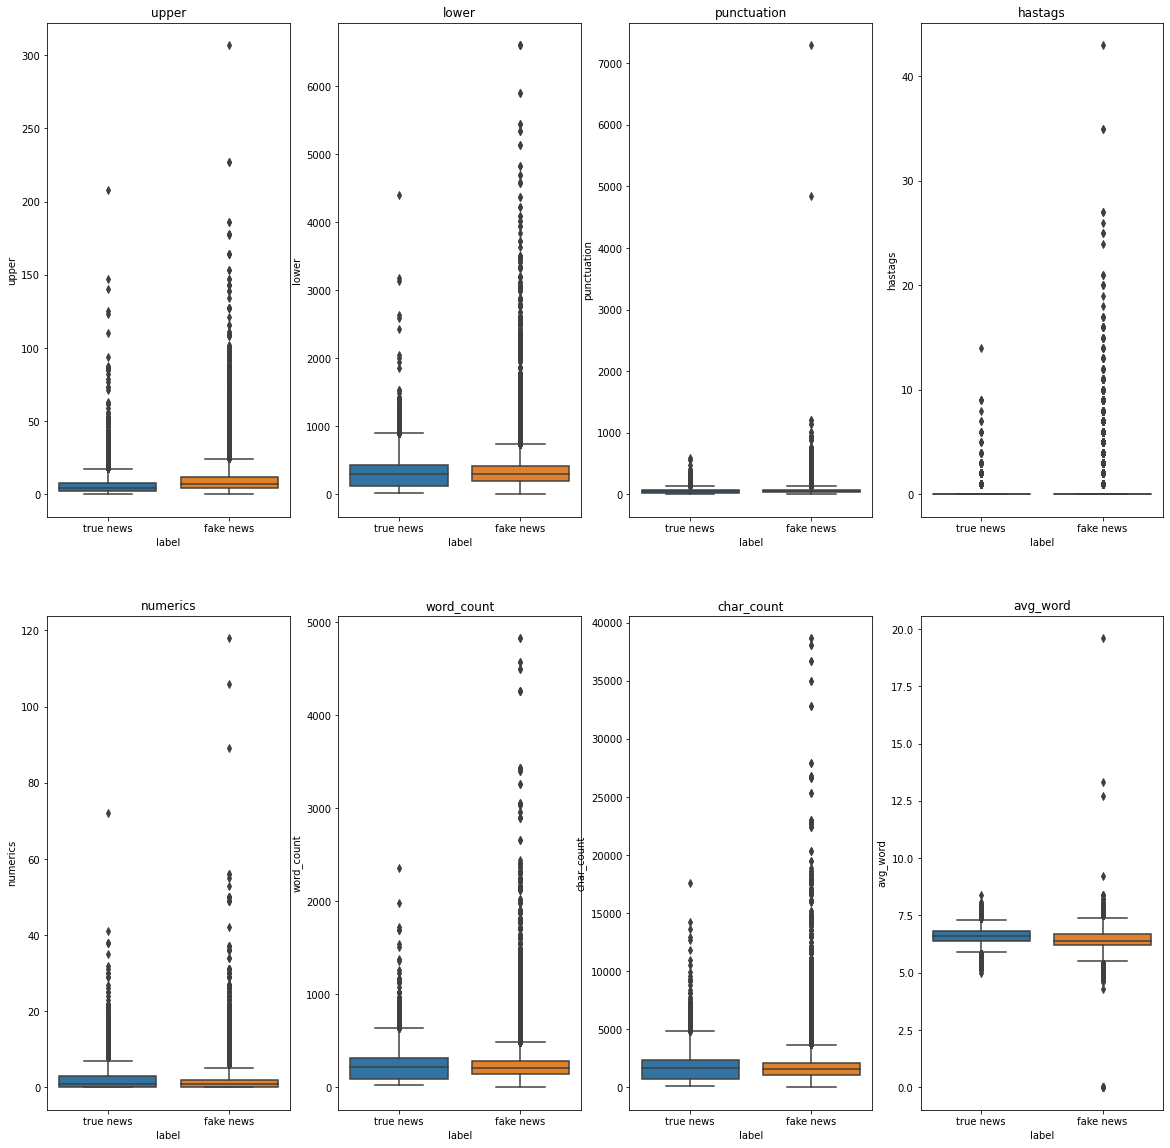

In [25]:
# boxplot dengan pencilan
num_columns = news.columns[4:]

plt.figure(figsize=(20, 20))
for ind, col in enumerate(num_columns):
    plt.subplot(2, 4, ind+1)
    sns.boxplot(data=news, y=col, x='label')
    plt.title(col)
plt.show()

Terlalu banyak pencilan yang cukup mengganggu. Saya coba melihat visualnya tanpa pencilan.

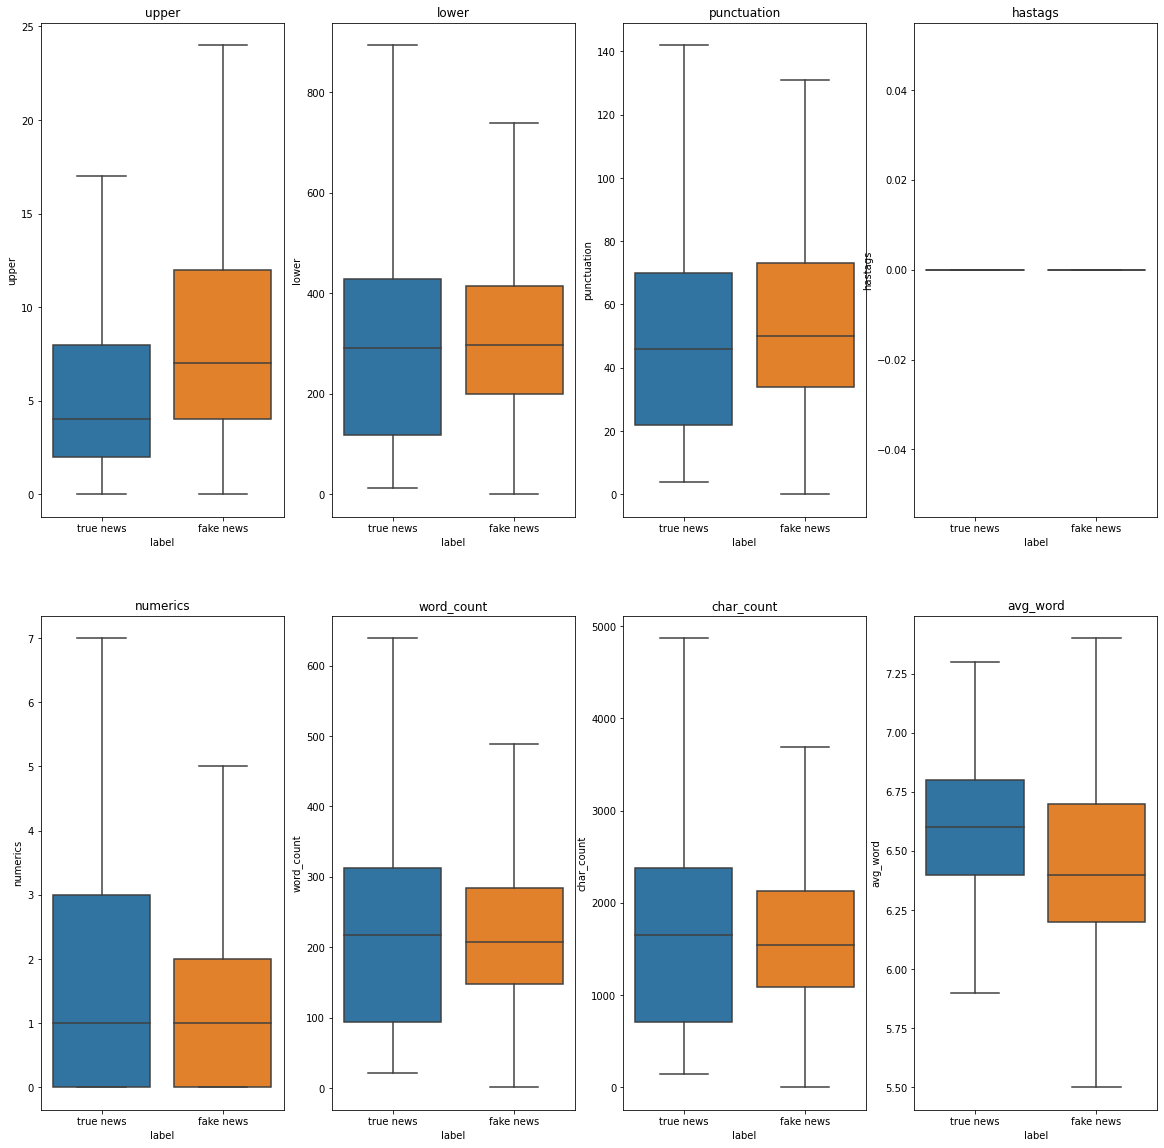

In [26]:
# boxplot tanpa pencilan
plt.figure(figsize=(20, 20))
for ind, col in enumerate(num_columns):
    plt.subplot(2, 4, ind+1)
    sns.boxplot(data=news, y=col, x='label', showfliers = False)
    plt.title(col)
plt.show()

Beberapa hal yang menarik yang ditemukan dari grafik adalah,
- Berita palsu lebih banyak menggunakan huruf besar dan hastag dibandingkan berita asli. Saya menduga sebagian besar berita palsu menggunakan huruf besar sebagai penekanan atau membuat berita terlihat lebih heboh. Sedangkan, penggunaan hastag agar berita lebih mudah tersebar,
- Berita asli lebih banyak menggunakan punctuation dan angka dibandingkan berita palsu. Saya menduga berita asli menggunakan banyak kutipan dan data angka untuk memberikan informasi berdasarkan data.

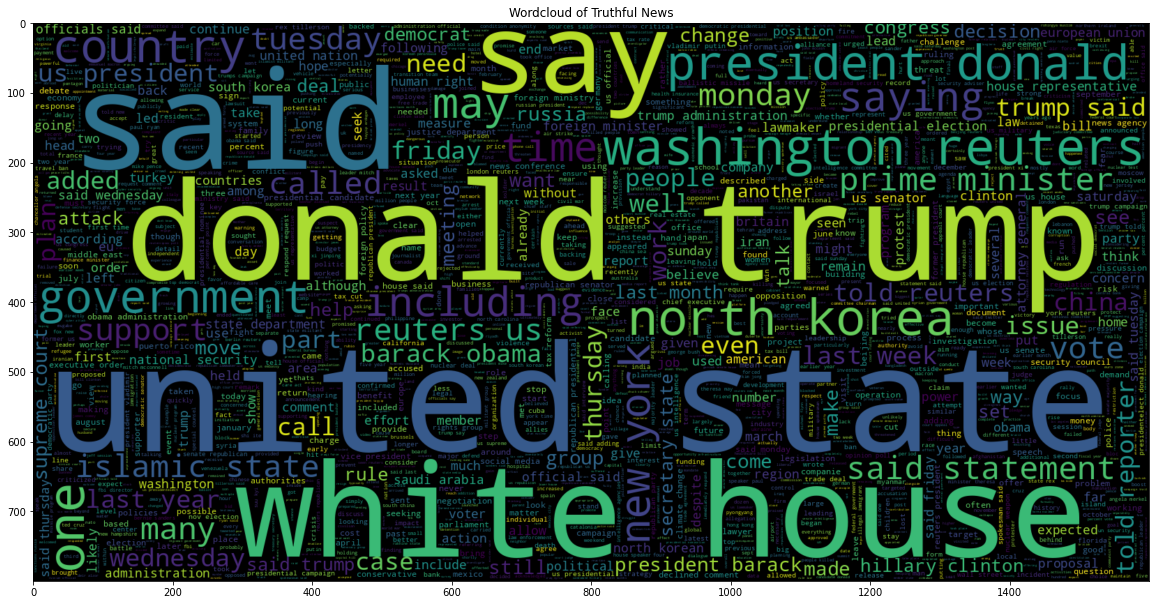

In [27]:
# visualisasi berita asli
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news.loc[news.label == 'true news', 'content']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Wordcloud of Truthful News")
plt.show()

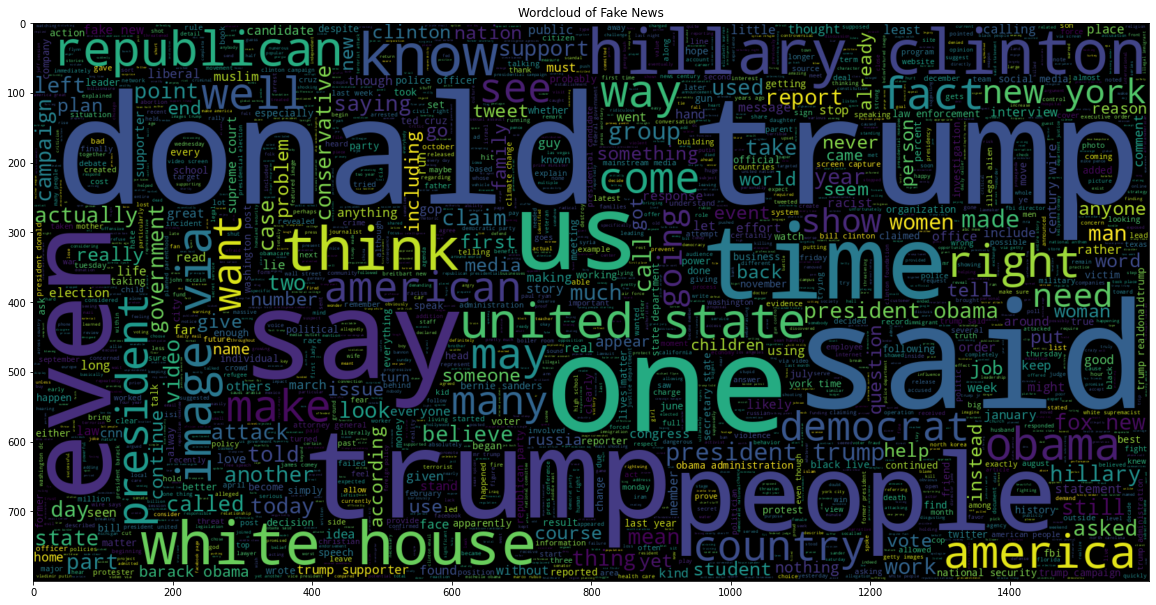

In [28]:
# visualisasi berita palsu
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(news.loc[news.label == 'fake news', 'content']))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Wordcloud of Fake News")
plt.show()

Sebagian besar dari kata-kata yang sering muncul pada berita asli dan palsu adalah "Donald Trump","said", dan "say". Hal ini wajar karena sebagian besar berita berisi tentang politik dan data dikumpulkan saat proses pemilu Amerika Serikat pada tahun 2016.

Pada wordcloud berita asli, salah satu kata yang sering muncul adalah "reuters", sedangkan Reuters adalah salah satu nama portal berita. Saya mencurigai hal ini akan berdampak pada saat model mencoba berita dari portal berita yang berbeda. Bisa saja model terlatih lebih mengenali berita dari Reuters sebagai berita asli, dan selain itu berita palsu.

## Data Preprocessing

### Check proportion of target

In [29]:
news.label.value_counts() / len(news)

fake news    0.518589
true news    0.481411
Name: label, dtype: float64

Target data looks balanced.

### Split the Data

In [30]:
X = news.content
y = news['label'].replace(('fake news', 'true news'), (1, 0))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 3)
print('Jumlah data train:', X_train.shape[0])
print('Jumlah data test:', X_test.shape[0])
print('Jumlah data validation:', X_val.shape[0])

Jumlah data train: 28196
Jumlah data test: 8812
Jumlah data validation: 7050


In [31]:
# perkiraan jumlah kosa kata
print("Jumlah kosa kata:", len(set(X_train.str.cat(sep=' ').split())))

Jumlah kosa kata: 163779


In [32]:
# jumlah kata terbanyak dalam satu data
print("Jumlah kata terbanyak dalams satu berita:", X_train.str.split().str.len().max())

Jumlah kata terbanyak dalams satu berita: 4827



### Tokenizer

In [33]:
# setup text vect
max_vocab_length = 10000
max_length = 300

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize=None,
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode='int',
                                       output_sequence_length=max_length)
text_vectorization.adapt(X_train)

2022-02-28 22:29:59.546676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:29:59.656170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:29:59.656929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-28 22:29:59.658700: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [34]:
# jumlah kosa kata setelah tokenisasi
print("Jumlah kosa kata setelah tokenisasi:", len(text_vectorization.get_vocabulary()))

Jumlah kosa kata setelah tokenisasi: 10000


### Create input data for pipeline

In [ ]:
def df_to_dataset(features, labels, shuffle=True, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

train_ds = df_to_dataset(X_train, y_train, batch_size=256)
val_ds = df_to_dataset(X_val, y_val, shuffle=False, batch_size=256)
test_ds = df_to_dataset(X_test, y_test, shuffle=False, batch_size=256)

## Model Definition
Saya menggunakan dummy classifier sebagai baseline model dan beberapa model machine learning untuk membandingkan dengan model deep learning.

### Baseline Model

In [38]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 3)

### Machine Learning
Saya hanya menggunakan Naive Bayes karena model lain membutuhkan RAM yang lebih besar untuk dataset ini.

In [39]:
# Naive Bayes
mnb = MultinomialNB()

### Deep Learning

In [40]:
embedding = Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=max_length)

In [41]:
# deep learning model 1
inputs = Input(shape=(1,), dtype="string")
x = text_vectorization(inputs)
x = embedding(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1, activation='sigmoid')(x)

model_1 = Model(inputs, outputs, name="GAPooling_model")
model_1.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["accuracy"])
model_1.summary()

Model: "GAPooling_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [42]:
# deep learning model 2 - LSTM
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = LSTM(64)(x)
outputs = Dense(1, activation='sigmoid')(x)
                                         
model_2 = Model(inputs, outputs, name="LSTM_model")
model_2.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["accuracy"])
model_2.summary()

Model: "LSTM_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [43]:
# deep learning model 3 - GRU
inputs = Input(shape=(1,), dtype='string')
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(64)(x)
outputs = Dense(1, activation='sigmoid')(x)
                                         
model_3 = Model(inputs, outputs, name="GRU_model")
model_3.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=["accuracy"])
model_3.summary()

Model: "GRU_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 300)               0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 128)          1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [44]:
# membuat dataframe untuk membandingkan hasil setiap model
results_df = pd.DataFrame(
    columns=['F1 Score', 'Accuracy'],
    index=['Dummy Classifier', 'Naive Bayes', 'DL Model 1', 'DL Model 2 LSTM', 'DL Model 3 GRU']
)
results_df

,F1 Score,Accuracy
Dummy Classifier,NaN,NaN
Naive Bayes,NaN,NaN
DL Model 1,NaN,NaN
DL Model 2 LSTM,NaN,NaN
DL Model 3 GRU,NaN,NaN


### Baseline Model

In [45]:
# Dummy Classifier
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
f1score = f1_score(y_test, y_pred)
accscore = accuracy_score(y_test, y_pred)
results_df.loc['Dummy Classifier', 'F1 Score'] = f1score
results_df.loc['Dummy Classifier', 'Accuracy'] = accscore
    
# Printing evaluation metric (f1-score) 
print("f1 score:", f1score)
print("accuracy score:", accscore)


f1 score: 0.527592612829199
accuracy score: 0.5094189741261915


Hasil Dummy Classifier sebagai baseline model tidak begitu tinggi.

In [46]:
# fungsi melakukan training pada model dan hasilnya
def modeling(Model, Xtrain, Xtest):
    model = Model
    model.fit(Xtrain, y_train)
    y_pred = model.predict(Xtest)
    return y_pred

# fungsi membuat confusion matrix
def conf_matrix(model_names, y_test, y_pred):
    plt.figure(figsize=(6, 6))
    plt.title(f'Confusion Matrix of {model_names}')
    ax = plt.subplot()
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap=plt.cm.Blues)
    ax.set_xlabel('Label Prediksi')
    ax.set_ylabel('Label Aktual')
    plt.show()

# fungsi menunjukkan hasil pelatihan model
def model_results(names, y_pred, y_test=y_test):
    score = f1_score(y_test, y_pred)
    accscore = accuracy_score(y_test, y_pred)
    results_df.loc[names, 'F1 Score'] = score
    results_df.loc[names, 'Accuracy'] = accscore
    
    print(f'----------   {names}   ----------')
    print("f1 score:", score)
    print("acc score:", accscore)
    print()
    conf_matrix(names, y_test, y_pred)
    print()
    print('Classification Report')
    print(classification_report(y_test, y_pred))

### Machine Learning

----------   Naive Bayes   ----------
f1 score: 0.9598134991119006
acc score: 0.9589196550158874



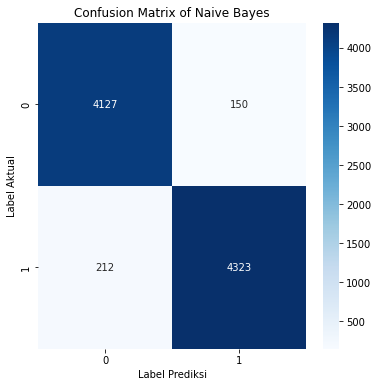


Classification Report
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4277
           1       0.97      0.95      0.96      4535

    accuracy                           0.96      8812
   macro avg       0.96      0.96      0.96      8812
weighted avg       0.96      0.96      0.96      8812



In [47]:
# Naive Bayes
vect = CountVectorizer()
X_train_vec = vect.fit_transform(X_train)
X_test_vec = vect.transform(X_test)

model_results('Naive Bayes', modeling(mnb, X_train_vec, X_test_vec))

Hasil dari Naive Bayes lebih baik dibanding baseline model dan nilainya jauh berbeda.

### Deep Learning
#### Model 1

In [48]:
model_1_hist = model_1.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
111/111 [==============================] - 3s 17ms/step - loss: 0.6078 - accuracy: 0.8628 - val_loss: 0.4847 - val_accuracy: 0.9077
Epoch 2/50
111/111 [==============================] - 2s 16ms/step - loss: 0.3713 - accuracy: 0.9276 - val_loss: 0.2902 - val_accuracy: 0.9377
Epoch 3/50
111/111 [==============================] - 2s 16ms/step - loss: 0.2367 - accuracy: 0.9526 - val_loss: 0.2081 - val_accuracy: 0.9460
Epoch 4/50
111/111 [==============================] - 2s 16ms/step - loss: 0.1734 - accuracy: 0.9651 - val_loss: 0.1612 - val_accuracy: 0.9637
Epoch 5/50
111/111 [==============================] - 2s 15ms/step - loss: 0.1356 - accuracy: 0.9738 - val_loss: 0.1320 - val_accuracy: 0.9712
Epoch 6/50
111/111 [==============================] - 2s 18ms/step - loss: 0.1103 - accuracy: 0.9792 - val_loss: 0.1129 - val_accuracy: 0.9738
Epoch 7/50
111/111 [==============================] - 2s 15ms/step - loss: 0.0920 - accuracy: 0.9842 - val_loss: 0.0978 - val_accuracy: 0.9782

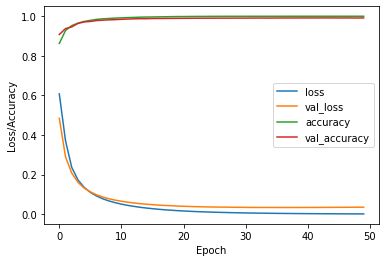

In [49]:
metrics = pd.DataFrame(model_1_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 1   ----------
f1 score: 0.9919700214132762
acc score: 0.9914893617021276



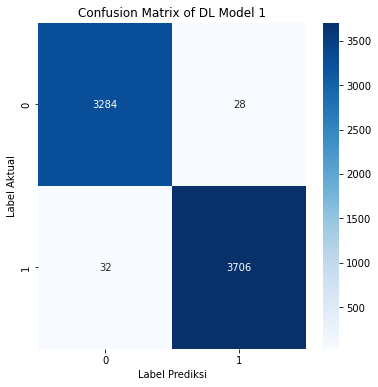


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3312
           1       0.99      0.99      0.99      3738

    accuracy                           0.99      7050
   macro avg       0.99      0.99      0.99      7050
weighted avg       0.99      0.99      0.99      7050



In [50]:
yval_pred = model_1.predict(X_val)
model_results('DL Model 1', np.round(yval_pred), y_val)

#### Model 2 - LSTM

In [51]:
model_2_hist = model_2.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50


2022-02-28 22:36:56.460287: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


111/111 [==============================] - 7s 39ms/step - loss: 0.4161 - accuracy: 0.8447 - val_loss: 0.3813 - val_accuracy: 0.8504
Epoch 2/50
111/111 [==============================] - 4s 39ms/step - loss: 0.2789 - accuracy: 0.9010 - val_loss: 0.2548 - val_accuracy: 0.9088
Epoch 3/50
111/111 [==============================] - 4s 36ms/step - loss: 0.2475 - accuracy: 0.9102 - val_loss: 0.3368 - val_accuracy: 0.8508
Epoch 4/50
111/111 [==============================] - 4s 38ms/step - loss: 0.2319 - accuracy: 0.9021 - val_loss: 0.1005 - val_accuracy: 0.9799
Epoch 5/50
111/111 [==============================] - 4s 36ms/step - loss: 0.0505 - accuracy: 0.9893 - val_loss: 0.0831 - val_accuracy: 0.9796
Epoch 6/50
111/111 [==============================] - 4s 37ms/step - loss: 0.1386 - accuracy: 0.9555 - val_loss: 0.0941 - val_accuracy: 0.9789
Epoch 7/50
111/111 [==============================] - 4s 36ms/step - loss: 0.0409 - accuracy: 0.9919 - val_loss: 0.1376 - val_accuracy: 0.9594
Epoch 8/50

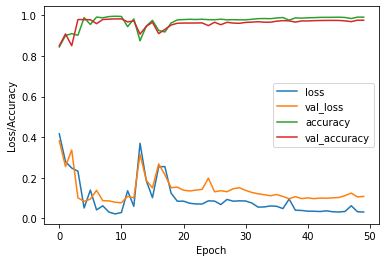

In [52]:
metrics = pd.DataFrame(model_2_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 2 LSTM   ----------
f1 score: 0.9775748623606821
acc score: 0.9763120567375887



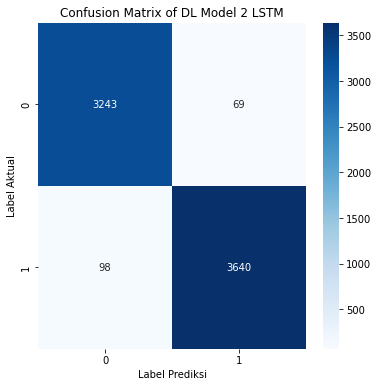


Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3312
           1       0.98      0.97      0.98      3738

    accuracy                           0.98      7050
   macro avg       0.98      0.98      0.98      7050
weighted avg       0.98      0.98      0.98      7050



In [53]:
yval_pred = model_2.predict(X_val)
model_results('DL Model 2 LSTM', np.round(yval_pred), y_val)

#### Model 3 - GRU

In [54]:
model_3_hist = model_3.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
111/111 [==============================] - 6s 39ms/step - loss: 0.4050 - accuracy: 0.8167 - val_loss: 1.2812 - val_accuracy: 0.4704
Epoch 2/50
111/111 [==============================] - 4s 34ms/step - loss: 0.6854 - accuracy: 0.5690 - val_loss: 0.6514 - val_accuracy: 0.6003
Epoch 3/50
111/111 [==============================] - 4s 34ms/step - loss: 0.5891 - accuracy: 0.6430 - val_loss: 0.2191 - val_accuracy: 0.9330
Epoch 4/50
111/111 [==============================] - 4s 35ms/step - loss: 0.2248 - accuracy: 0.9418 - val_loss: 0.2381 - val_accuracy: 0.9176
Epoch 5/50
111/111 [==============================] - 4s 34ms/step - loss: 0.5513 - accuracy: 0.7299 - val_loss: 0.5387 - val_accuracy: 0.7774
Epoch 6/50
111/111 [==============================] - 4s 36ms/step - loss: 0.3685 - accuracy: 0.8662 - val_loss: 0.3348 - val_accuracy: 0.8804
Epoch 7/50
111/111 [==============================] - 4s 35ms/step - loss: 0.2689 - accuracy: 0.9117 - val_loss: 0.2948 - val_accuracy: 0.8997

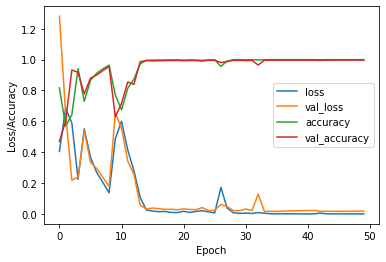

In [55]:
metrics = pd.DataFrame(model_3_hist.history)
metrics[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot()
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.show()

----------   DL Model 3 GRU   ----------
f1 score: 0.9971913869198875
acc score: 0.9970212765957447



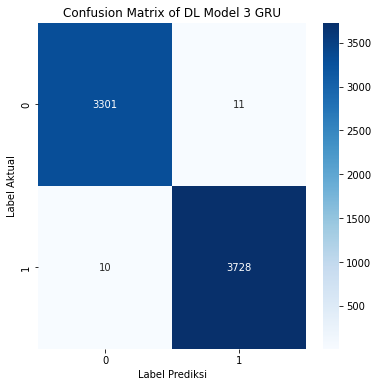


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3312
           1       1.00      1.00      1.00      3738

    accuracy                           1.00      7050
   macro avg       1.00      1.00      1.00      7050
weighted avg       1.00      1.00      1.00      7050



In [56]:
yval_pred = model_3.predict(X_val)
model_results('DL Model 3 GRU', np.round(yval_pred), y_val)

## Model Evaluation

In [57]:
results_df

,F1 Score,Accuracy
Dummy Classifier,0.527593,0.509419
Naive Bayes,0.959813,0.95892
DL Model 1,0.99197,0.991489
DL Model 2 LSTM,0.977575,0.976312
DL Model 3 GRU,0.997191,0.997021


- Jika dibandingkan dengan baseline model dan model Naive Bayes, hasil dari model deep learning menunjukkan hasil yang lebih baik.
- Model 3 deep learning menggunakan GRU menunjukkan hasil yang terbaik di antara lain. Grafik loss antara data train dan validation juga tidak jauh berbeda. Hal ini menunjukkan bahwa model GRU tidak overfitting.
- Berbeda dengan model 3, model 1 menggunakan pooling memiliki skor yang tidak jauh berbeda dengan model 3, tetapi pada grafik loss, model 1 terlihat overfitting.

Selanjutnya kita coba model 3 (model terbaik) pada data test. Apakah model masih bisa memprediksi dengan hasil yang baik?

----------   DL Model 3 GRU   ----------
f1 score: 0.9982374972460895
acc score: 0.9981842941443486



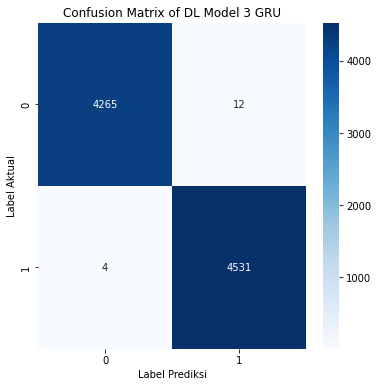


Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4277
           1       1.00      1.00      1.00      4535

    accuracy                           1.00      8812
   macro avg       1.00      1.00      1.00      8812
weighted avg       1.00      1.00      1.00      8812



In [61]:
ytest_pred = model_3.predict(X_test)
model_results('DL Model 3 GRU', np.round(ytest_pred), y_test)

Model 3 mampu memprediksi data tes dengan tingkat akurasi 99,8%. Bahkan, hasil akurasinya lebih besar dibandingkan prediksi data validasi. Saya menganggap model 3 sudah baik untuk digunakan.

## Model Saving

In [67]:
# save model terbaik
model_3.save('fakenews_pred_model')

## Model Inference
Data yang digunakan untuk pelatihan adalah data tahun 2016. Sehingga, saya mencoba untuk menggunakan data berita asli dan palsu terbaru, untuk menguji kemampuan model dengan data terbaru. 

### True News Sample

In [68]:
# truthful news
# https://www.reuters.com/world/us/hats-flags-deafening-cheers-conservative-gathering-consecrates-trump-2022-02-28/
sample_news1 = """
Trump consecrated at conservative gathering
ORLANDO, Florida, Feb 28 (Reuters) - At a large weekend gathering of conservatives in Florida, attendees browsed a sea of merchandise emblazoned with "Trump": Pink cowboy hats, sparkly purses, and T-shirts touting him as the 2024 presidential candidate.

But buried within the brassy rows of Trump merchandise at The MAGA Mall store were hats touting another figure: Florida's Republican Governor Ron DeSantis, who is seen as a potential 2024 rival to former President Donald Trump, who has hinted repeatedly that he wants to run again.

DeSantis is the only governor for whom Ronald Solomon, owner of The MAGA Mall, says he sells merchandise. Yet, if the store's sales are predictive of political wins, Trump need not fret. For every DeSantis hat sold, Solomon said he sells around 50 featuring Trump.

"It's Trump's party," Solomon said of the Republican Party as he attended to a group of young women at his stall at the Conservative Political Action Conference (CPAC), a get-together of American right-wing notables, in Orlando, more famous as the home of the Walt Disney World theme park.

That was unquestionably the maxim at the four-day CPAC gathering that ended on Sunday, according to interviews with more than a dozen Republican voters, right-wing media figures and conservative pundits who professed support for the former president.

Trump spoke to a rapturous crowd on Saturday, underlining his hold over the Republican base ahead of November's congressional elections.

Slightly improving his results from last year's poll at the Orlando gathering, Trump received 59% of support in a straw poll on possible 2024 White House contenders.

CPAC tends to draw from the more conservative wing of the Republican Party, and its polls are not necessarily a reliable predictor of the eventual nominee.

Trump has not confirmed another run for the White House, but has hinted at it heavily - calling himself the "45th and 47th" president of the United States in a recent social media video. He alluded to it again in his speech on Saturday, saying "we're going to be doing it again, a third time."

Still, Trump's laser fixation on falsely claiming he was the victim of fraud in the 2020 election, which he lost to Democrat Joe Biden, has some establishment Republicans worried he is more interested in nursing grievances than charting the party's future.

But Trump's pull with the base - his frequent rallies attract big crowds and many congressional candidates crave his endorsement - means establishment worries could ultimately be immaterial.

"We will make America proud again! We will make America safe again! And we will make America great again!" Trump said as he wrapped up Saturday night's speech to deafening cheers.

CPAC, which touts itself as the "largest and most influential" worldwide gathering of conservatives, gives potential candidates nationwide media exposure and a chance to generate buzz.

Given Trump's dominance, only the congressional, criminal and civil investigations into Trump seem to have the potential to derail the 75-year-old former real estate magnate from running, said Doug Heye, a former Republican aide.

Trump is dealing with a New York state civil inquiry into his family business and a congressional panel looking into the deadly Jan. 6, 2021, attack on the U.S. Capitol by supporters seeking to overturn the election results.

"It's not just that it can knock him off the pedestal," said Heye. "It could cause him to remove himself from the pedestal."

'WE LISTEN TO TRUMP'

At The MAGA Mall, retiree and Republican activist Nicole Bommarito, 49, already decked out in a T-shirt insulting Vice-President Kamala Harris, bought a "TRUMP WON" cowboy hat.

"Trump is the person we listen to," said Bommarito, who moved to Florida from New York last year because she felt the state better reflected her values. Still, her alternative 2024 candidate reflected Solomon's inventory: "If Donald Trump doesn't run, DeSantis is our first pick."

She is not alone: When asked at CPAC for whom they would vote if Trump doesn't throw his hat in, 61% chose DeSantis.

The MAGA Mall's owner, Solomon, who criss-crosses the country to sell merchandise at Trump rallies, was certain that Trump, who has endorsed dozens of midterm candidates and publishes near-daily statements attacking Biden, would run.

"He's not going to hand this off to somebody else. It would be like him building a building in New York and giving it to Seymour Durst," said Solomon, referring to the late real estate mogul.

Many CPAC attendees said DeSantis, a 43-year-old former lawyer with three young children and a wife who has been battling breast cancer, could easily wait and run for president in 2028.

DeSantis did not give any hints about his plans during his CPAC speech, which made no mention of Trump or 2024. Instead, DeSantis touted himself as a principled fighter keeping Florida open for business in the face of hysteria over COVID-19.

While his speech was well-received, DeSantis was given a speaking slot on Thursday, the more thinly attended first day of the conference. Buzz around him had largely waned by the weekend.

Back at The MAGA Mall, Bommarito decided not to buy any DeSantis merchandise. "I'll get it tomorrow," she said.
"""

In [69]:
# truthful news
# https://edition.cnn.com/2022/02/24/europe/ukraine-russia-conflict-explainer-2-cmd-intl/index.html
sample_news2 = """
What does Putin want in Ukraine? The conflict explained
After months of military buildup and brinkmanship on its border with Ukraine, Russia invaded its ex-Soviet neighbor with a multi-pronged attack, threatening to destabilize Europe and draw in the United States.

A whirlwind of diplomatic efforts to stave off a Russian invasion in recent weeks failed to defuse tensions that had mounted over months.
Russia had been tightening its military grip around Ukraine since last year, amassing tens of thousands of soldiers, as well as equipment and artillery, on the country's doorstep.
Black smoke rises from a military airport in Chuguyev near Kharkiv, the second-largest city in Ukraine, on Thursday.
The escalation in the years-long conflict between Russia and Ukraine has triggered the greatest security crisis in Europe since the Cold War. Russia's attacks on several parts of Ukraine raise the specter of a dangerous showdown between Western powers and Moscow.
So how did we get here? The picture on the ground is shifting rapidly, but here's a breakdown of what we know.
What's the situation on the border?
Several areas across Ukraine came under attack on Thursday morning after Russian President Vladimir Putin declared the start of a "special military operation" and warned of bloodshed unless Ukrainian forces lay down their arms.
The move came after months of speculation about what Moscow's intentions were with the troops it had massed on the Ukrainian border. More than 150,000 Russian troops encircled the country on three sides, like a sickle, according to estimates from US and Ukrainian intelligence officials.
Some of those forces began pouring across the border, crossing into Ukraine from the north in Belarus and to the south from Crimea, according to the Ukrainian State Border Service. Elsewhere, explosions rang out in multiple cities, including the capital Kyiv.
The coordinated assault came days after Putin announced that Moscow would officially recognize the self-declared Donetsk and Luhansk People's Republics (DNR and LNR), in eastern Ukraine's Donbas region, ordering the deployment of Russian troops there in what was widely believed to be the opening salvo to a broader military confrontation.
The territory recognized by Putin extended beyond the areas controlled by pro-Russian separatists, raising red flags about Russia's intended creep into Ukraine.
Russia repeatedly denied it was planning an assault, but an escalation in shelling in eastern Ukraine heightened fears that it could be stoking the violence to justify a wider conflict.
As the situation on Ukraine's border has intensified, NATO has raised the readiness of its rapid response force, while member countries put troops on standby and deployed battalions, planes and ships to the region. US President Joe Biden said Thursday the US would deploy additional troops to Germany and redeploy some forces already in Europe to NATO eastern flank allies. In recent weeks, the US has sent several thousand soldiers into NATO countries in Eastern Europe.
The US says it has no intention of sending troops into Ukraine, which is not a NATO member. On Thursday, NATO's Secretary General, Jens Stoltenberg condemned the Russian attack as a "grave breach of international law, and a serious threat to Euro-Atlantic security."
Also on Thursday, the US unveiled new sanctions that will cut off certain strategic imports to Russia, adding to a "first tranche" of measures targeting two large financial institutions, the country's sovereign debt, and Russian elites and their family members. Biden has vowed the world will "hold Russia accountable" for the invasion, and is expected to spell out a set of additional sanctions, which were once meant to deter such an assault.
Biden and European leaders have previously warned that Russia would suffer serious consequences should Putin move ahead with a wider invasion. But that has not stopped Russia from continuing to bolster its military positions.
In late 2021 and early 2022, satellite images revealed new Russian deployments of troops, tanks, artillery and other equipment cropping up in multiple locations, including near eastern Ukraine, Crimea and Belarus, where its forces were participating in joint drills with Moscow's closest international ally.
Despite receiving funding, training and equipment from the US and other NATO member countries, experts say Ukraine would be significantly outmatched by Russia's military, which has been modernized under Putin's leadership. If an all-out war broke out between the two countries, tens of thousands of civilians could die and up to 5 million could be made refugees, according to some estimates.
What has set the stage for the conflict?
Ukraine was a cornerstone of the Soviet Union until it voted overwhelmingly for independence in a democratic referendum in 1991, a milestone that turned out to be a death knell for the failing superpower.
After the collapse of the Soviet Union, NATO pushed eastward, bringing into the fold most of the Eastern European nations that had been in the Communist orbit. In 2004, NATO added the former Soviet Baltic republics Estonia, Latvia and Lithuania. Four years later, it declared its intention to offer membership to Ukraine some day in the distant future -- crossing a red line for Russia.
Putin sees NATO's expansion as an existential threat, and the prospect of Ukraine joining the Western military alliance a "hostile act" -- a view he invoked in a televised speech on Thursday, saying that Ukraine's aspiration to join the military alliance was a dire threat to Russia.
In interviews and speeches, Putin has previously emphasized his view that Ukraine is part of Russia, culturally, linguistically and politically. While some of the mostly Russian-speaking population in Ukraine's east feel the same, a more nationalist, Ukrainian-speaking population in the west has historically supported greater integration with Europe.
In early 2014, mass protests in the capital Kyiv known as Euromaidan forced out a Russia-friendly president after he refused to sign an EU association agreement. Russia responded by annexing the Ukrainian peninsula of Crimea and fomenting a separatist rebellion in Ukraine's east, which seized control of part of the Donbas region. Despite a ceasefire agreement in 2015, the two sides have not seen a stable peace, and the front line has barely moved since. Nearly 14,000 people have died in the conflict, and there are 1.5 million people internally displaced in Ukraine, according to the Ukrainian government.
In the eight years since, Moscow has been accused of engaging in hybrid warfare against Ukraine, using cyberattacks, economic pressure and propaganda to whip up discord. Those tactics have escalated in recent months, and in early February the State Department claimed Putin was preparing a false-flag operation to create "a pretext for an invasion."
What does Putin want?
In a lengthy essay penned in July 2021, Putin referred to Russians and Ukrainians as "one people," and suggested the West had corrupted Ukraine and yanked it out of Russia's orbit through a "forced change of identity."
That type of historical revisionism was on full display in Putin's emotional and grievance-packed address to the nation on Monday announcing his decision to recognize the Donetsk and Luhansk People's Republics, while casting doubt on Ukraine's own sovereignty.
But Ukrainians, who in the last three decades have sought to align more closely with Western institutions like the European Union and NATO, have pushed back against the notion that they are little more than the West's "puppet."
In fact, Putin's efforts to bring Ukraine back into Russia's sphere have been met with a backlash, with several recent polls showing that a majority of Ukrainians now favor membership of the US-led transatlantic military alliance.
In December, Putin presented the US and NATO with a list of security demands. Chief among them was a guarantee that Ukraine will never enter NATO and that the alliance rolls back its military footprint in Eastern and Central Europe -- proposals that the US and its allies have repeatedly said are non-starters.
Putin indicated he was not interested in lengthy negotiations on the topic. "It is you who must give us guarantees, and you must do it immediately, right now," he said at his annual news conference late last year. "Are we deploying missiles near the US border? No, we are not. It is the United States that has come to our home with its missiles and is already standing at our doorstep."
High-level talks between the West and Russia wrapped in January without any breakthroughs. The standoff left Europe's leaders to engage in a frenzy of shuttle diplomacy, exploring whether a negotiating channel established between France, Germany, Russia and Ukraine to resolve the conflict in Ukraine's east -- known as the Normandy Format talks -- could provide an avenue for calming the current crisis.
In a news conference with the new German Chancellor Olaf Scholz on February 16, Putin repeated unsubstantiated claims that Ukraine is carrying out a "genocide" against Russian speakers in the Donbas region and called for the conflict to be resolved through the Minsk peace progress -- echoing similar rhetoric that was used as a pretext for annexing Crimea.

But less than a week later, after Russia's upper house of parliament approved the deployment of military forces outside the country on February 22, Putin told reporters that the Minsk agreements "no longer exist," adding: "What is there to implement if we have recognized these two entities?"
The agreements, known as Minsk 1 and Minsk 2 -- which were hammered out in the Belarusian capital in a bid to end a bloody in eastern Ukraine -- have never been fully implemented, with key issues remaining unresolved.
Moscow and Kyiv have long been at odds over key elements of the peace deal, the second of which was inked in 2015 and lays out a plan for reintegrating the two breakaway republics into Ukraine. Ukrainian President Volodymyr Zelensky recently stated that he did not like a single point of the Minsk accords, which require dialogue on local elections in the Russian-backed separatist regions and -- although unclear in what sequence -- would also restore the Ukrainian government's control over its eastern borders. Critics say the agreement could give Moscow undue sway over Ukrainian politics.
Putin previously responded in blunt terms by saying that regardless of whether Zelensky likes the plan, it must be implemented. "Like it or don't like it, it's your duty, my beauty," Putin said in a news conference alongside French President Emmanuel Macron. Zelensky, a former comedian and TV star, won a 2019 election in a landslide on promises to end the war in Donbas, but little has changed. Responding to a question about Putin's stark, undiplomatic language, Zelensky responded in Russian, saying bluntly: "We are not his."
What is Ukraine's view?
President Zelensky previously downplayed the danger of all-out war with Russia, noting that the threat has existed for years and that Ukraine is prepared for military aggression. But on Thursday, as Russia launched an assault on his country, Zelensky made an emotional address directly to the Ukrainian people, declaring martial law in the country.
"Russia began an attack on Ukraine today. Putin began war against Ukraine, against the entire democratic world. He wants to destroy my country, our country, everything we've been building, everything we are living for," Zelensky said in a video message posted on his official Facebook page.
In Kyiv, where Ukrainians had continued to go about their daily business while Russian troops sat at their borders, the streets were empty on Thursday.
Across the country, residents have been preparing for the worst -- packing emergency evacuation kits and taking time out of their weekends to train as reservists.
Ukraine's government insists that Moscow cannot prevent Kyiv from building closer ties with NATO, or otherwise interfere in its domestic or foreign politics. "Russia cannot stop Ukraine from getting closer with NATO and has no right to have any say in relevant discussions," the Foreign Ministry said in a statement to CNN.
Tensions between the two countries have been exacerbated by a deepening Ukrainian energy crisis that Kyiv believes Moscow has purposefully provoked. Ukraine views the controversial Nord Stream 2 pipeline -- connecting Russian gas supplies directly to Germany -- as a threat to its own security.
Nord Stream 2 is one of two pipelines that Russia has laid underwater in the Baltic Sea -- in addition to its traditional land-based pipeline network that runs through eastern Europe, including Ukraine. Kyiv views the pipelines across Ukraine as an element of protection against invasion by Russia, since any military action could potentially disrupt the vital flow of gas to Europe.
After requests from Zelensky and the US administration, German Chancellor Olaf Scholz said on Tuesday that he would halt the certification of the pipeline following Putin's decision to order troops into parts of eastern Ukraine.
Nord Stream 2 is just one of myriad challenges facing Zelensky's government. The former actor, who played a president on Ukrainian television, has had a brutal baptism of fire into real-world politics since assuming office in 2019.
His government's popularity has stagnated amid multiple domestic political challenges, including a recent third wave of Covid-19 infections and a struggling economy.
Many Ukrainians are unhappy that the government has not delivered on the promises that brought it into power, including cracking down on corruption in the country's judicial system. But the more pressing concern is Zelensky's failure so far to bring peace to the country.
"""

In [70]:
# truthful news
# https://www.aljazeera.com/news/2022/2/28/ukraine-russia-india-and-pakistan-walk-similar-diplomatic-tightrope
sample_news3 = """
India, Pakistan take a similar diplomatic path on Russia-Ukraine
India and Pakistan have both stressed the importance of Russia and Ukraine de-escalating hostilities.
New Delhi/Islamabad – India and Pakistan have both emphasised the importance of de-escalation in Ukraine following Russia’s invasion, while carefully avoiding ascribing responsibility for the violence, with the nuclear-armed South Asian neighbours attempting to walk differing diplomatic high-wires, analysts say.

On Sunday, Pakistani foreign minister Shah Mahmood Qureshi spoke via telephone with his Ukrainian counterpart, Dmytro Kuleba, reiterating Pakistan’s call for a cessation of hostilities.
The language of Pakistan’s statements on the crisis has been similar to that of India’s at the United Nations Security Council (UNSC) and in telephone conversations between Indian Prime Minister Narendra Modi and the Russian and Ukrainian leadership.

On Saturday, Modi spoke with Ukrainian President Volodymyr Zelenskyy, stressing the need to end the violence without ascribing responsibility for it.

“[Modi] reiterated his call for an immediate cessation of violence and a return to dialogue, and expressed India’s willingness to contribute in any way towards peace efforts,” read an Indian foreign ministry statement following the call.

Two days earlier, on the day Russia invaded Ukraine, Modi spoke with Russian President Vladimir Putin using similar language.

“Prime Minister [Modi] reiterated his longstanding conviction that the differences between Russia and the NATO group can only be resolved through honest and sincere dialogue,” read an Indian statement.

“[Modi] appealed for an immediate cessation of violence, and called for concerted efforts from all sides to return to the path of diplomatic negotiations and dialogue.”

At the UNSC, India abstained from a vote on a resolution that would have “deplored” Russia’s actions in Ukraine.

On Thursday, Pakistan’s Prime Minister Imran Khan was in Moscow for talks with President Putin on a major gas pipeline deal and regional issues, including Afghanistan.

The Russian statement on that meeting was brief, making no mention of Ukraine, while PM Khan’s office took a guarded approach to broaching the subject of the invasion, saying Pakistan “regretted” the current situation.

“Prime Minister [Khan] stressed that conflict was not in anyone’s interest, and that the developing countries were always hit the hardest economically in case of conflict,” said the Pakistani statement.

“He underlined Pakistan’s belief that disputes should be resolved through dialogue and diplomacy.”

So, why all the apparent equivocating?
India’s longstanding ties with Russia
India and Russia have had warm ties for decades, which analysts say are mainly due to Russian arms exports to the South Asian country as well as other areas of cooperation.

India has also developed much closer ties with the United States in recent years, evidenced by India’s in the US’s Asia-Pacific “Quad” defence alliance aimed at countering China.

According to the Stockholm International Peace Research Institute (SIPRI), an estimated 23 percent of all Russian arms exports between 2016 to 2020 went to India, accounting for 49 percent of all Indian arms imports in the same period.

In December 2021, India said it had begun to receive deliveries of the Russian S-400 ground-to-air missile defence system, following a visit that month by President Putin to New Delhi.

Analysts say India’s abstention at the UNSC vote could be a result of both the large arms imports and India’s more nuanced position on issues related to conflicts involving the US, Russia and China.

“I see it mainly with respect to India’s longstanding ties with Russia and the fact of our dependence on military supplies and partially we believe that Russia has some genuine concerns which could have been taken into consideration,” said Sanjay Kumar Pandey, who teaches Russian foreign policy at New Delhi’s Jawaharlal Nehru University.

Pandey added that India’s statements, focused on the need for diplomacy, make it “very difficult to derive a clear-cut meaning”.

“India has […] not supported Russia’s actions, Russia’s recognition of breakaway republics [in eastern Ukraine], or Russia’s military intervention in Ukraine,” he said.

“But at the same time, if we say diplomacy was not given a chance, it can be construed mainly against Russia, but also partially Ukraine and NATO.”

On Thursday, President Joe Biden said the US was still in unresolved “consultations” with India over the crisis.

PS Raghavan, a former Indian ambassador to Russia, said that when people say India has not taken a “clear stand” on the conflict, they are focused on one thing: “India is not condemning Russia. That’s all that they mean when they say that.”

Raghavan said it was “not a matter of pleasing both [the US and Russia]”.

“We have very strong relations with Russia, we have very strong relations with the US. Our relations with the US have become stronger in the last decade, but each stands on its own. We don’t have any binary in the international system any more after the Cold War.”

The conception of there being a diplomatic tightrope or balancing act, he said, “is actually a creation of […] the media and some of the academic community”.

On the question of Pakistani PM Khan’s presence in Moscow on the day of the invasion, both analysts suggested it was more a case of coincidence.

“[PM Khan] did not know Russia is going to attack [Ukraine] on that day,” said Raghavan. “That’s just coincidental because I don’t think anybody knew Russia was going to attack.”

Realignment of Pakistan’s interests
In Pakistan, PM Khan faced domestic criticism from some quarters for having visited Russia on the day of the invasion, sitting alongside Putin for a photo opportunity before a roughly three-hour meeting between the two leaders.

Pakistan’s ties with Russia have increased in recent years, after being unfriendly during the Cold War, when Pakistan was a key US regional ally in countering Russian forces in Afghanistan.

Khan’s visit to Russia was the first by a Pakistani prime minister in more than two decades, although former president Asif Ali Zardari met then-Russian President Dmitry Medvedev in Moscow in 2011.

High on the agenda was meant to be the Pakistan Stream gas pipeline, a proposed 1,100km (684-mile) pipeline running from the Pakistani port city of Karachi to the central Punjab province. The project was conceived in 2015 but faced numerous delays until new agreements were drawn up in 2021.

The pipeline, to be built at an estimated cost of $2.5bn, will be capable of transporting 12.4bn cubic metres of natural gas annually.

Analysts say that while the gas pipeline would likely not be increasing Russian gas exports, it may divert some Middle East gas supplies to Pakistan, making Europe more reliant on Russian natural gas.

Pakistan and Russia have also increased contacts through the former’s now full membership of the Shanghai Cooperation Organisation (SCO).

In December, Pakistani PM Khan has also lauded President Putin’s comments on how insults to Islam’s Prophet Muhammad should be seen as a “violation of religious freedom”.

Analysts say the main takeaway from the talks should be the new importance Russia appears to have taken on.

“Pakistan has little to do with Russia’s decision to go ahead with a war being planned for months,” said Salman Zaidi, director of programmes at the Islamabad-based Jinnah Institute think-tank.

“The objective of the meeting was strategic symbolism for both sides, and definitely stoked anxieties in capitals accustomed to Islamabad’s traditional alignment with the West in security cooperation.”

Zaidi said the fact that no major agreements were signed during the visit was secondary.

“The way the meeting was orchestrated by the Russians shows they view this relationship with new importance,” he said.

Zaidi said regional developments since mid-2021, including the US exit from Afghanistan and the Taliban’s takeover, have “demand[ed] realignment from countries like Pakistan”.

“Pakistan will stay in the Western camp, but potentially counterbalance its security needs with a partnership with Russia in the long term,” he said.

As for Ukraine, given the limited economic and other ties between the two countries – total trade between them in 2020-2021 was $350m, according to Pakistani central bank data – Zaidi says the stakes for Pakistan are relatively low.

“[Pakistan] does not have a voting position at the UNSC, nor has it been called upon by Ukraine to demand an end to violence,” he said.

“Pakistan is not related to the Ukraine conflict in any meaningful way, nor is South Asia, as can be seen by statements from leaderships across the region.”
"""

### Fake News Sample

In [71]:
# fake news based on https://libguides.valenciacollege.edu/c.php?g=612299&p=4251645
# https://greatgameindia.com/coronavirus-bioweapon/
sample_news4 = """
Coronavirus Bioweapon – How China Stole Coronavirus From Canada And Weaponized It 
Last year a mysterious shipment was caught smuggling Coronavirus from Canada. It was traced to Chinese agents working at a Canadian lab. Subsequent investigation by GreatGameIndia linked the agents to Chinese Biological Warfare Program from where the virus is suspected to have leaked causing the Wuhan Coronavirus outbreak.
The Saudi SARS Sample
On June 13, 2012 a 60-year-old Saudi man was admitted to a private hospital in Jeddah, Saudi Arabia, with a 7-day history of fever, cough, expectoration, and shortness of breath. He had no history of cardiopulmonary or renal disease, was receiving no long-term medications, and did not smoke.

Egyptian virologist Dr. Ali Mohamed Zaki isolated and identified a previously unknown coronavirus from his lungs. After routine diagnostics failed to identify the causative agent, Zaki contacted Ron Fouchier, a leading virologist at the Erasmus Medical Center (EMC) in Rotterdam, the Netherlands, for advice.
Fouchier sequenced the virus from a sample sent by Zaki. Fouchier used a broad-spectrum “pan-coronavirus” real-time polymerase chain reaction (RT-PCR) method to test for distinguishing features of a number of known coronaviruses known to infect humans.
"""

In [72]:
sample_news5 = """
Exposed: FBI Director James Comey’s Clinton Foundation Connection
A review of FBI Director James Comey’s professional history and relationships shows that the Obama cabinet leader — now under fire for his handling of the investigation of Hillary Clinton — is deeply entrenched in the big-money cronyism culture of Washington, D.C. His personal and professional relationships — all undisclosed as he announced the Bureau would not prosecute Clinton — reinforce bipartisan concerns that he may have politicized the criminal probe.

These concerns focus on millions of dollars that Comey accepted from a Clinton Foundation defense contractor, Comey’s former membership on a Clinton Foundation corporate partner’s board, and his surprising financial relationship with his brother Peter Comey, who works at the law firm that does the Clinton Foundation’s taxes.

Lockheed Martin

When President Obama nominated Comey to become FBI director in 2013, Comey promised the United States Senate that he would recuse himself on all cases involving former employers.

But Comey earned $6 million in one year alone from Lockheed Martin. Lockheed Martin became a Clinton Foundation donor that very year.

Comey served as deputy attorney general under John Ashcroft for two years of the Bush administration. When he left the Bush administration, he went directly to Lockheed Martin and became vice president, acting as a general counsel.

How much money did James Comey make from Lockheed Martin in his last year with the company, which he left in 2010? More than $6 million in compensation.

Lockheed Martin is a Clinton Foundation donor. The company admitted to becoming a Clinton Global Initiative member in 2010.

According to records, Lockheed Martin is also a member of the American Chamber of Commerce in Egypt, which paid Bill Clinton $250,000 to deliver a speech in 2010.

In 2010, Lockheed Martin won 17 approvals for private contracts from the Hillary Clinton State Department.

HSBC Holdings

In 2013, Comey became a board member, a director, and a Financial System Vulnerabilities Committee member of the London bank HSBC Holdings.

“Mr. Comey’s appointment will be for an initial three-year term which, subject to re-election by shareholders, will expire at the conclusion of the 2016 Annual General Meeting,” according to HSBC company records.

HSBC Holdings and its various philanthropic branches routinely partner with the Clinton Foundation. For instance, HSBC Holdings has partnered with Deutsche Bank through the Clinton Foundation to “retrofit 1,500 to 2,500 housing units, primarily in the low- to moderate-income sector” in “New York City.”

“Retrofitting” refers to a Green initiative to conserve energy in commercial housing units. Clinton Foundation records show that the Foundation projected “$1 billion in financing” for this Green initiative to conserve people’s energy in low-income housing units.

Who Is Peter Comey?

When our source called the Chinatown offices of D.C. law firm DLA Piper and asked for “Peter Comey,” a receptionist immediately put him through to Comey’s direct line. But Peter Comey is not featured on the DLA Piper website.

Peter Comey serves as “Senior Director of Real Estate Operations for the Americas” for DLA Piper. James Comey was not questioned about his relationship with Peter Comey in his confirmation hearing.

DLA Piper is the firm that performed the independent audit of the Clinton Foundation in November during Clinton-World’s first big push to put the email scandal behind them. DLA Piper’s employees taken as a whole represent a major Hillary Clinton 2016 campaign donation bloc and Clinton Foundation donation base.

DLA Piper ranks #5 on Hillary Clinton’s all-time career Top Contributors list, just ahead of Goldman Sachs.

And here is another thing: Peter Comey has a mortgage on his house that is owned by his brother James Comey, the FBI director.

Peter Comey’s financial records, obtained by Breitbart News, show that he bought a $950,000 house in Vienna, Virginia, in June 2008. He needed a $712,500 mortgage from First Savings Mortgage Corporation.

But on January 31, 2011, James Comey and his wife stepped in to become Private Party lenders. They granted a mortgage on the house for $711,000. Financial records suggest that Peter Comey took out two such mortgages from his brother that day.

This financial relationship between the Comey brothers began prior to James Comey’s nomination to become director of the FBI.

DLA Piper did not answer Breitbart News’ question as to whether James Comey and Peter Comey spoke at any point about this mortgage or anything else during the Clinton email investigation.

Peter Comey Re-Designed the FBI Building

FBI Director James Comey grew up in the New Jersey suburbs with his brother Peter. Both Comeys were briefly taken captive in 1977 by the “Ramsey rapist,” but the boys managed to escape through a window in their home, and neither boy was harmed.

James Comey became a prosecutor who worked on the Gambino crime family case. He went on to the Bush administration, a handful of private sector jobs, and then the Obama administration in 2013.

Peter Comey, meanwhile, went into construction.

After getting an MBA in real estate and urban development from George Washington University in 1998, Peter Comey became an executive at a company that re-designed George Washington University between 2004 and 2007 while his brother was in town working for the Bush administration.

In January 2009, at the beginning of the Obama administration, Peter Comey became “a real estate and construction consultant” for Procon Consulting.

Procon Consulting’s client list includes “FBI Headquarters Washington, DC.”

So what did Procon Consulting do for FBI Headquarters? Quite a bit, apparently. According to the firm’s records:

Procon provided strategic project management for the consolidation of over 11,000 FBI personnel into one, high security, facility.

Since 1972 the Federal Bureau of Investigation has had its headquarters in a purpose built 2.1 million square foot building on Pennsylvania Avenue. Having become functionally obsolete and in need of major repairs, GSA and the FBI were considering ways to meet the space needs required to maintain the Bureau’s mission and consolidate over 11,000 personnel.

Procon assisted GSA in assessing the FBI’s space needs and options for fulfilling those needs. Services provided included project management related to site evaluations, budgeting, due diligence, and the development of procurement and funding strategies.

Those “funding strategies” included talking to “stakeholders”: “Worked with stakeholders and key leadership to identify strategic objectives, goals and long range plans for capital and real estate projects.”

Procon Consulting obtained its contract for FBI Headquarters prior to James Comey’s nomination to serve as director of the FBI.

In June 2011, Peter Comey left Procon Consulting to become “Senior Director of Real Estate Operations for the Americas” for DLA Piper.

Peter Comey has generated some controversy in that role. According to Law360 in May 2013 (the same month that James Comey was confirmed as someone being considered by Obama to become FBI director):

Two real estate services businesses filed a $10 million suit against the law firm Monday alleging it stiffed them on as much as $760,000 of work done at DLA Piper’s Chicago office and improperly gave proprietary information to a competitor.

….

The plaintiffs take particular aim at Peter Comey, DLA Piper’s senior director of real estate operations. Leasecorp and SpaceLogik include several emails in the complaint that are purportedly from DLA Piper senior real estate partners Jay Epstein and Rich Klawiter and are sharply critical of Comey’s handling of the matter. In one email, Epstein wrote that “it’s an embarrassment for the firm to be treating someone who we are working with like this.”

In another email allegedly from Klawiter on Feb. 20, the DLA Piper partner informed Leasecorp President Michael Walker, a principal for both plaintiffs, that Comey had sent him and Epstein an email claiming that the real estate services firms were behind on their contractual obligations.

“I just received an email from Peter (Jay was also a recipient) that is so inflammatory I can’t even send it or you’ll hit the roof,” Klawiter said in the email, according to the complaint. “This is not going to end well.”"""

In [76]:
sample_news6 ="""
Fact Check: 10 Reasons We Believed Queen Elizabeth Was Dead
Tuesday afternoon Hollywood Unlocked posted an “Exclusive” that Queen Elizabeth II had passed away.

Not surprisingly, breaking what could have been the most newsworthy story of the decade caused a tidal wave of reactions on social media, with many questioning how site founder Jason Lee had somehow managed to scoop everyone – including major British outlets – on such a massive bombshell. 

ADVERTISEMENT
On behalf of our small but mighty team, we want to first say that we heard your concerns and acknowledge the sensitivity around this topic. We not only understand the global reach of the British monarchy, but also recognize that above all else The Queen is a mother, grandmother, and beloved public figure who deserves to be approached with respect. 

Given the confusion our original post has caused, Lee and everyone else at this publication would like to take a moment to thoughtfully lay out exactly why HU believed the 95-year-old royal had passed away and felt empowered to report it. 

Tuesday, February 22nd Hollywood Unlocked CEO, Jason Lee was contacted directly from a source who was in attendance at the wedding of British Vogue editor-in-chief Edward Enninful. The source claimed they witnessed a call in which news of the Queen’s death had been confirmed to a high-profile attendee. They went on to outline the dismay that news created at the star-studded event.  
While many have scoffed at the idea that the Queen or anyone associated with her would ever attend Enninful’s wedding, not only is he fashion royalty in the UK, a quick Google image search easily pulls up pictures of him sharing intimate moments with members of the royal family such as the Queen’s eldest son Prince Charles, 73, her 74-year-old daughter-in-law Camilla, Duchess of Cornwall and other members of their inner circle.
The Queen was last publicly sighted Wednesday, Feb 16th when she hosted visitors at Windsor Castle. At the time, analysts speculated that video taken of her greeting incoming defense services secretary Maj. Gen. Eldon Millar and his predecessor, Rear Adm. James Macleod was shared in an attempt to assure the public that she was in good health. 
However, four days later on Sunday, Feb 20th, Buckingham Palace conceded that the Queen had tested positive for COVID-19. It was subsequently announced that due to her diagnosis that she would cease taking in-person meetings.
Given her COVID diagnosis, and the credibility of our original source, Lee then spoke to another source familiar with the British military. This person confirmed directly to Lee that the palace had been locked down and all the top generals had been summoned to Windsor Castle “for an undisclosed reason” just four hours before Hollywood Unlocked broke the news. 
It is also worth noting that earlier this month Queen Elizabeth II announced Camilla, Duchess of Cornwall, will be known as “Queen Consort” once Prince Charles takes over the throne. This illustrates that her mortality was an ongoing discussion that could not be ignored as she celebrates an unprecedented 70 years on the throne.
Breaking the news that Britain’s longest-reigning monarch has passed is no simple matter and as we previously reported, there is an extensive game plan in place for that occurrence that has been dubbed Operation London Bridge. The accounts we received on Tuesday were aligned with the approach of that protocol and appeared to further substantiate claims that Her Majesty’s health had taken a turn for the worse.
Given the current ​​Ukraine-Russia crisis, we understand that the world is in a space of political unrest right now and have seen the reports that UK Prime Minister Boris Johnson spoke to Her Majesty on Wednesday, February 23rd, a full day after our report. 
Hollywood Unlocked reached out to Buckingham Palace for an official statement on this matter but has received no response to date. Instead, on Thursday, February 24th the BBC reported that a palace spokesperson released a statement announcing that The Queen had postponed two virtual appearances that were scheduled for that afternoon, adding, “No other engagements are scheduled for this week.”
Although several publications have dismissively characterized Hollywood Unlocked as just a “tabloid” site, as a matter of record, up until this point all of our sources have delivered us accurate accounts that have later been substantiated by larger publications.  So breaking stories before anyone else is not uncommon or atypical for us. 
All news outlets get it wrong sometimes despite their best efforts and we will always take full accountability when that happens.

But we can’t stress enough that we’d never intentionally cause unnecessary pain or grief to the monarchy (or the public at large) simply for “clickbait” and hope we’ve outlined all the compelling information that led to our original post. 

We take pride in the work we do and the relationships we’ve built behind the scenes that enable us to break stories directly to our audience – even at times when powerful media machines are working hard to distort the truth. 

“Although I’ve never been wrong when breaking a story because this involves The Queen this is one time I would want to be,” Lee clarified Thursday afternoon. “And based on Wednesday’s report from the Palace, I can say my sources got this wrong and I sincerely apologize to The Queen and the Royal Family.”
"""

In [77]:
sample_news = [sample_news1,
               sample_news2,
               sample_news3,
               sample_news4,
               sample_news5,
               sample_news6]

for ind, sample in enumerate(sample_news):
    sample = clean_text(sample)

    hasil = model_3.predict([sample])
    if np.round(hasil) == 1:
        print(f"{ind+1}. That's fake news.")
    else:
        print(f"{ind+1}. That isn't fake news.")

1. That isn't fake news.
2. That isn't fake news.
3. That isn't fake news.
4. That's fake news.
5. That's fake news.
6. That's fake news.


Wow, model berhasil memprediksi semua berita dengan benar.

## Kesimpulan
- Berita palsu lebih banyak menggunakan huruf besar sebagai penekanan agar terlihat lebih heboh. Sedangkan dan menggunakan hastag agar berita lebih mudah tersebar. Sedangkan, berita asli lebih banyak menggunakan punctuation dan angka karena berita asli menggunakan kutipan dan data angka untuk memberikan informasi berdasarkan data.
- Model deep learning menghasilkan skor terbaik dibandingkan baseline model dan model machine learning Naive Bayes. Model deep learning menggunakan pooling dan LSTM menunjukkan hasil yang overfitting. Model Deep Learning menggunakan GRU merupakan model terbaik dalam memprediksi pada kumpulan data berita dengan nilai akurasi 99,7%.